## Prueba CSV

In [22]:
import csv
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
from datetime import datetime
from datetime import timezone

Se impórta los archivos csv y se leen con read_csv con la libreria pandas, el primer parametro es para la ruta del archivo y el segundo el separador de los datos.

In [23]:
hP = pd.read_csv('Humedad_Patron.csv', names = ["Dia", "Hora", "H"])
hS = pd.read_csv('Humedad_Station.csv', names = ["Ut", "H"])

Se copian los dataset para mantener los archivos originales sin cambios, ademas se dejan los datos lo mas parecidos posible.

In [24]:
HP = hP.copy()
HS = hS.copy()

In [25]:
HP.head()

,Dia,Hora,H
0,05/12/17,2:15 p,75
1,05/12/17,2:20 p,75
2,05/12/17,2:25 p,74
3,05/12/17,2:30 p,73
4,05/12/17,2:35 p,73


In [26]:
HS.head()

,Ut,H
0,1511906403,58.34
1,1511906405,57.54
2,1511906407,58.18
3,1511906409,58.18
4,1511906412,58.18


se convierte los dataset en matices

In [27]:
MHP = HP.values
MHS = HS.values

se convierte el tiempo Ut para el dataset 2

In [28]:
hPU = [] # inicializar arreglo para humedad patron en unixtime
for i in MHP:
    if i[1].split(' ')[1] == 'a':
        h24 = str(datetime.strftime(datetime.strptime(i[1].split(' ')[0] + ' AM', '%I:%M %p'),"%H:%M"))
    else:
        h24 = str(datetime.strftime(datetime.strptime(i[1].split(' ')[0] + ' PM', '%I:%M %p'),"%H:%M"))
    hDT = datetime(int('20'+i[0][6:8]), int(i[0][3:5]), int(i[0][:2]), int(h24[0:2]), int(h24[3:5]))
    hU = hDT.replace(tzinfo=timezone.utc).timestamp()
    hPU.append([hU, i[2]])
hPU = np.array(hPU)

se convierte a pandas de nuevo

In [29]:
MHPpd = pd.DataFrame({'UT':hPU[:,0],'H':hPU[:,1]})
MHSpd = pd.DataFrame({'UT':MHS[:,0],'H':MHS[:,1]})

se ordenan los datos

In [30]:
HPpd = MHPpd.sort_values(by=['UT'])
HSpd = MHSpd.sort_values(by=['UT'])

In [31]:
HPpd.head()

,UT,H
0,1.512483e+09,75.0
1,1.512484e+09,75.0
2,1.512484e+09,74.0
3,1.512484e+09,73.0
4,1.512484e+09,73.0


In [32]:
HSpd.head()

,UT,H
0,1.511906e+09,58.34
1,1.511906e+09,57.54
2,1.511906e+09,58.18
3,1.511906e+09,58.18
4,1.511906e+09,58.18


se grafica

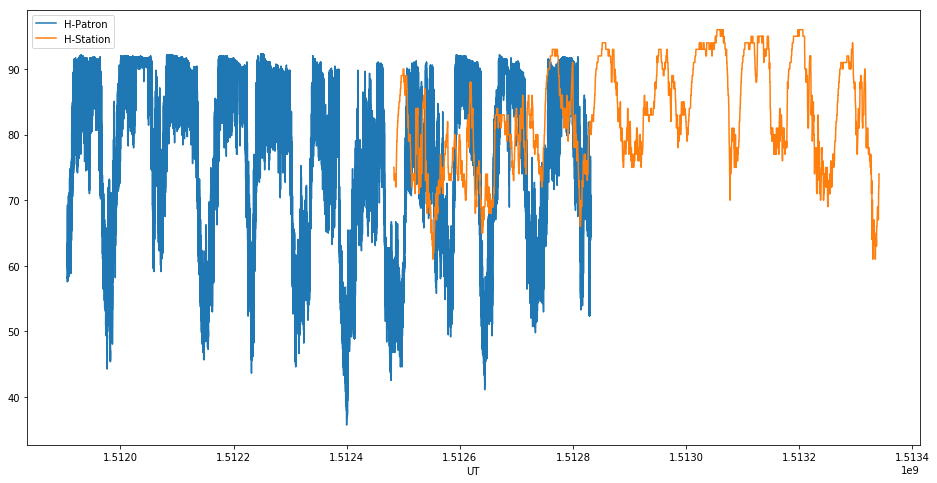

In [33]:
ax = HSpd.plot(x="UT", y="H",label="H-Patron")
HPpd.plot(figsize=(16, 8),ax=ax,x="UT", y="H",label="H-Station")

se miden los tamaños de los dataset para hacer la seleccion de datos

In [34]:
len(HPpd)

2850

In [35]:
len(HSpd)

420425

Se optiene el minimo y maximo de los valores ques que se van a usar 

In [36]:
minU = HPpd.UT[0]
maxU = HSpd.UT[len(HSpd)-1]

se reduce al intervalo minU y maxU

In [37]:
HPrd = HPpd[lambda HPpd:(HPpd.UT > minU) & (HPpd.UT < maxU)]
HSrd = HSpd[lambda HSpd:(HSpd.UT > minU) & (HSpd.UT < maxU)]

se grafica

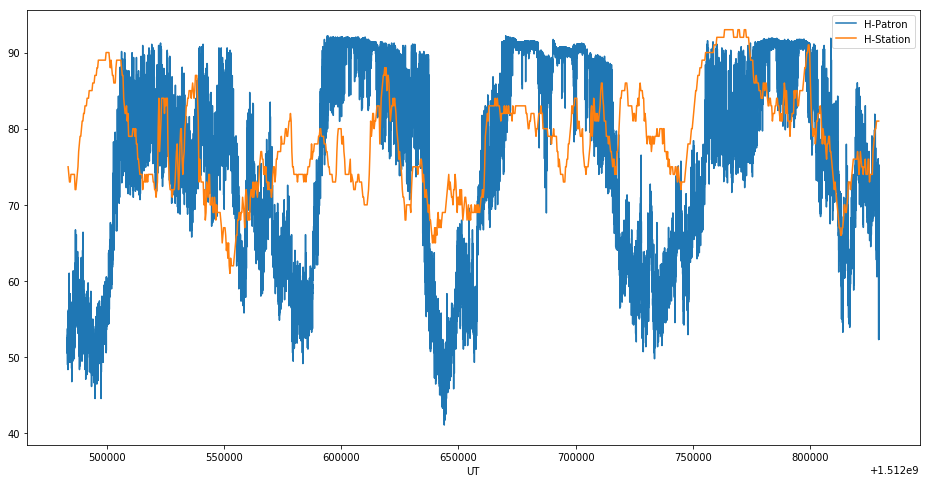

In [38]:
ax = HSrd.plot(x="UT", y="H",label="H-Patron")
HPrd.plot(figsize=(16, 8),ax=ax,x="UT", y="H",label="H-Station")

se busca una relacion de tamaño entre humedad patron y humedad station

In [39]:
print("humedad patron: %s, humedad station: %s" % ( len(HPrd), len(HSrd)))
print("Relación tamaño humedad station vs humedad patron: %s" % (len(HSrd)/len(HPrd)))

humedad patron: 1149, humedad station: 156710
Relación tamaño humedad station vs humedad patron: 136.3881636205396


se genera un arreglo con los indices a eliminar de HSrd y se eliminan para dejarlos del mismo tamaño

In [40]:
eHSrd = []
for i in range (0, len(HSrd)-1):
    if np.mod(i, 136) != 0:
        eHSrd.append(i)
HSrd.drop(HSrd.index[eHSrd], inplace=True)
HSrd.drop(HSrd.index[range(len(HPrd), len(HSrd)-1)], inplace=True)

se grafica

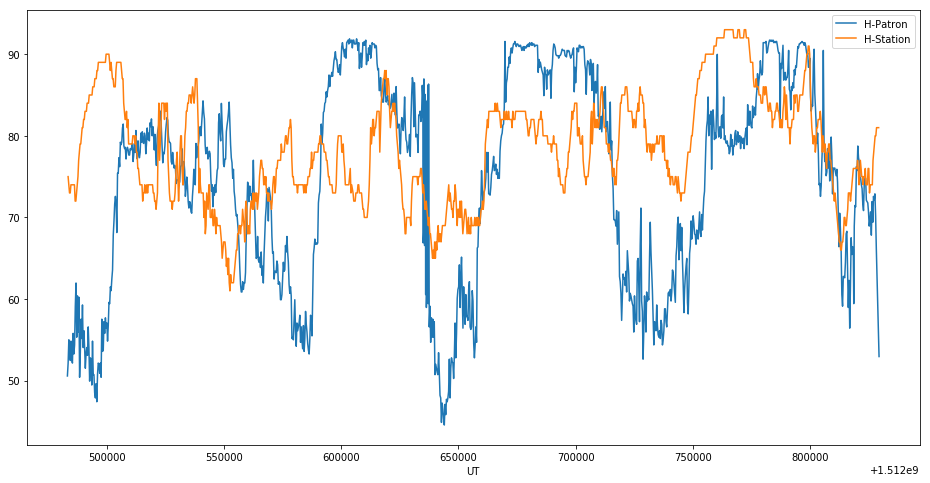

In [41]:
ax = HSrd.plot(x="UT", y="H",label="H-Patron")
HPrd.plot(figsize=(16, 8),ax=ax,x="UT", y="H",label="H-Station")

ahora se calculan las distancias

In [42]:
print("humedad patron: %s, humedad ptation: %s" % ( len(HPrd), len(HSrd)))

humedad patron: 1149, humedad ptation: 1150


In [46]:
suma = 0
for i in range(len(HPrd)):
    distancia_punto_i = (HPrd.iloc[i]["H"] - HSrd.iloc[i]["H"])**2 + (HPrd.iloc[i]["UT"] - HSrd.iloc[i]["UT"])**2
    suma = suma + distancia_punto_i

print("Suma distancias")
print(suma)
print("Raiz suma distancias")
print(math.sqrt(suma))
print("Promedio distancia")
print(math.sqrt(suma)/len(HPrd))

Suma distancias
1288203873.7321987
Raiz suma distancias
35891.557137190335
Promedio distancia
31.23721247797244


In [48]:
a = pd.DataFrame({'A': HSrd["H"].values,'B': HSrd["UT"].values})
b = pd.DataFrame({'A': HPrd["H"].values,'B': HPrd["UT"].values})

print("Distancia Euclideana desde A hasta B")
print(np.linalg.norm(a-b))
print("Distancia Euclideana desde A hasta B Manual")
print(math.sqrt(np.sum(np.sum((a-b)**2,axis=1))))
print("Distancia Euclideana Máxima desde A hasta B por puntos")
print(math.sqrt(max(np.sum((a-b)**2,axis=1))))

Distancia Euclideana desde A hasta B
nan
Distancia Euclideana desde A hasta B Manual
35891.55713719036
Distancia Euclideana Máxima desde A hasta B por puntos
2016.0175416151517


converitr datos del dataset en funciones y luego de obtener las funciones use el intervalo de tiempo para sacar la diferencia